# Import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('data/heart.csv', index_col=0)

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]

# Exploration

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172.0,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156.0,N,1.0,Flat,1
2,37,M,NaN,130,283,0,ST,98.0,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108.0,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122.0,N,0.0,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   907 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           899 non-null    float64
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 93.2+ KB


In [5]:
df.isna().sum().sum() #pour contrôler le nombre de NaN dans le DF

30

In [6]:
df.HeartDisease.value_counts() # on observe la proportion de notre target

1    508
0    410
Name: HeartDisease, dtype: int64

In [7]:
df.HeartDisease.value_counts(normalize=True) # on observe la proportion en % de notre target

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

## Features numériques

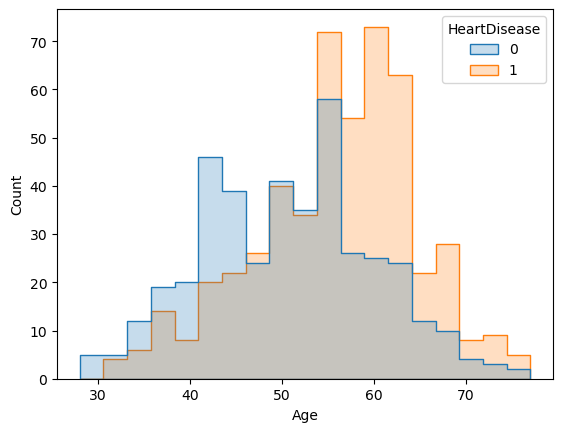

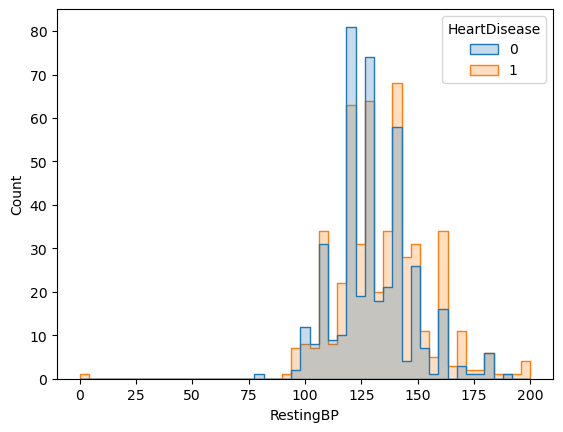

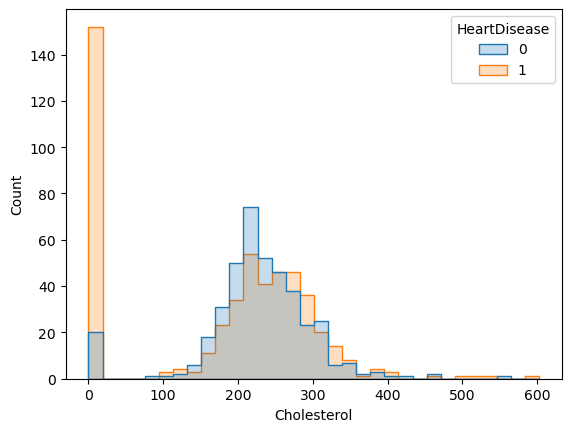

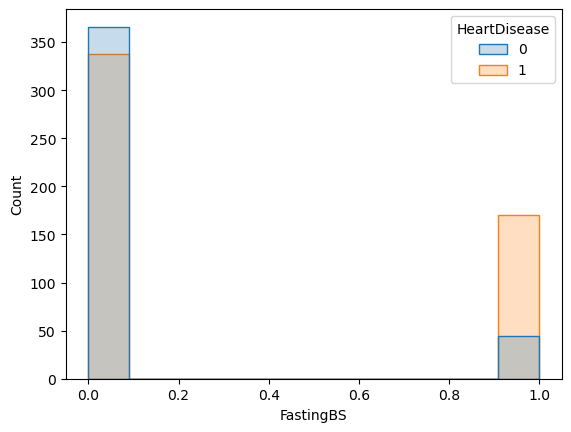

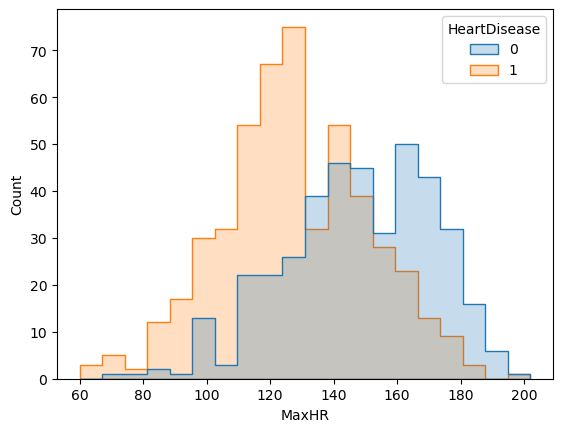

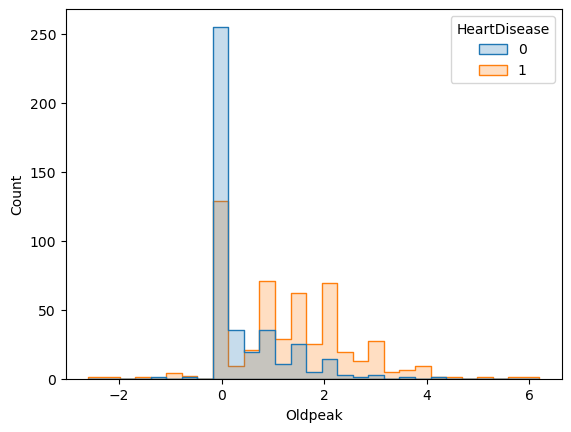

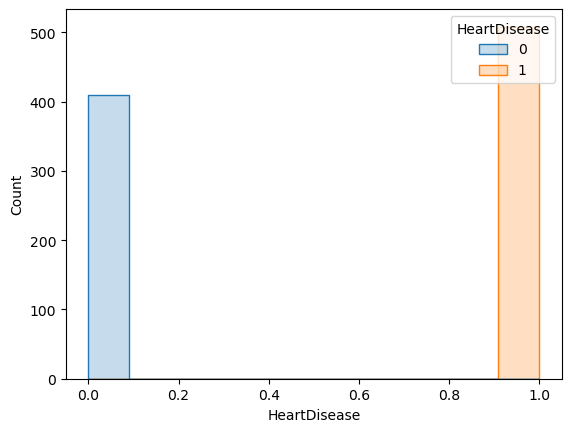

In [8]:
# on obeserve la distribution des variables num en prenant en compte la target
for column in df.select_dtypes('number').columns :
    sns.histplot(data=df, x=column, hue='HeartDisease',element="step")
    plt.show()

<Axes: >

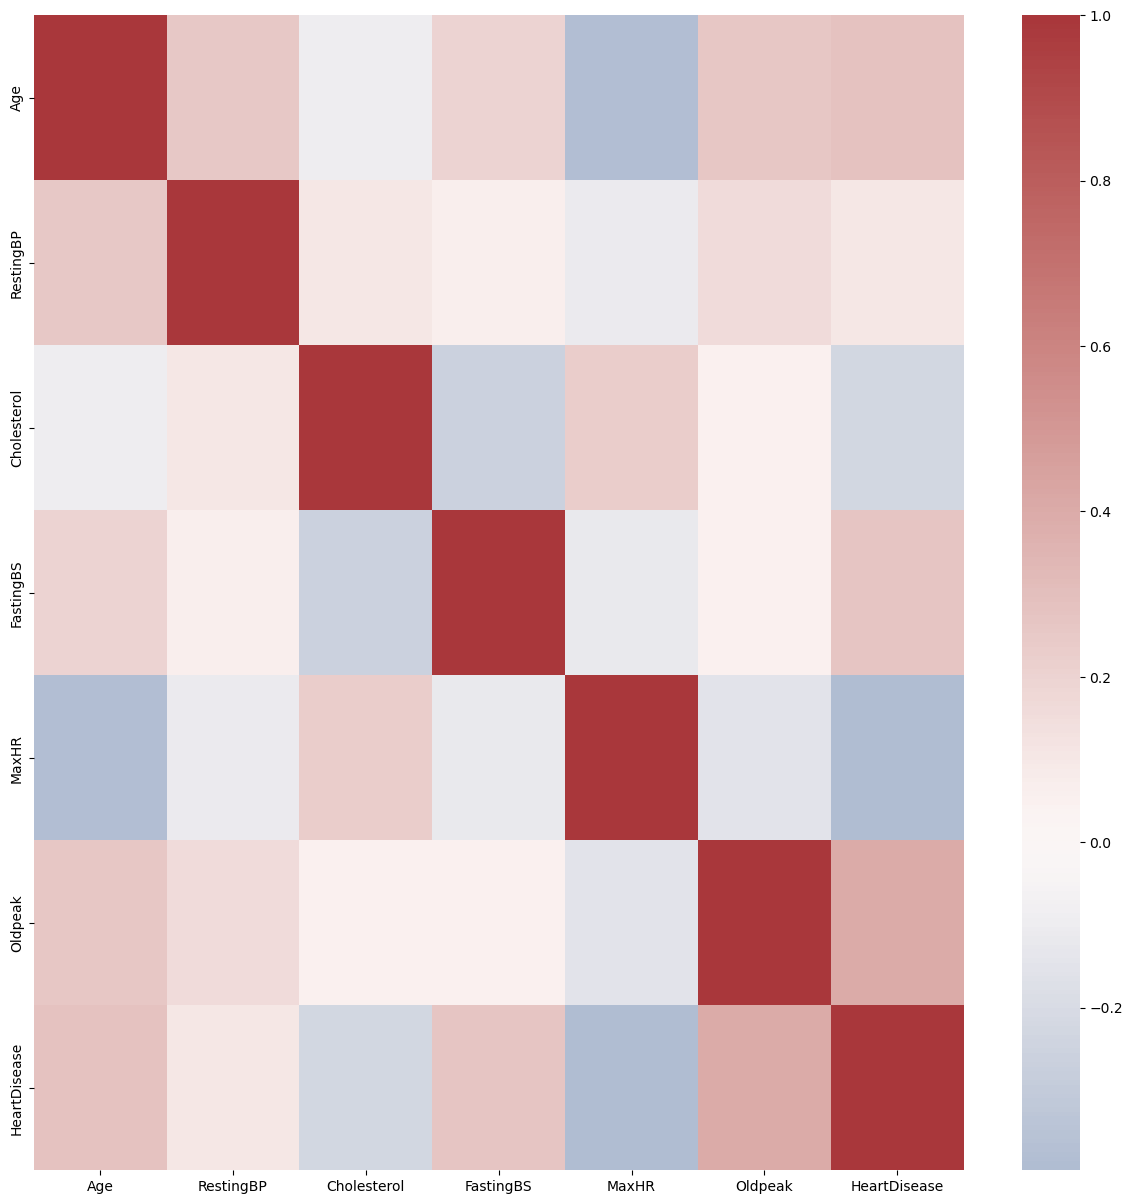

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(df.select_dtypes('number').corr(), center=0, cmap='vlag')

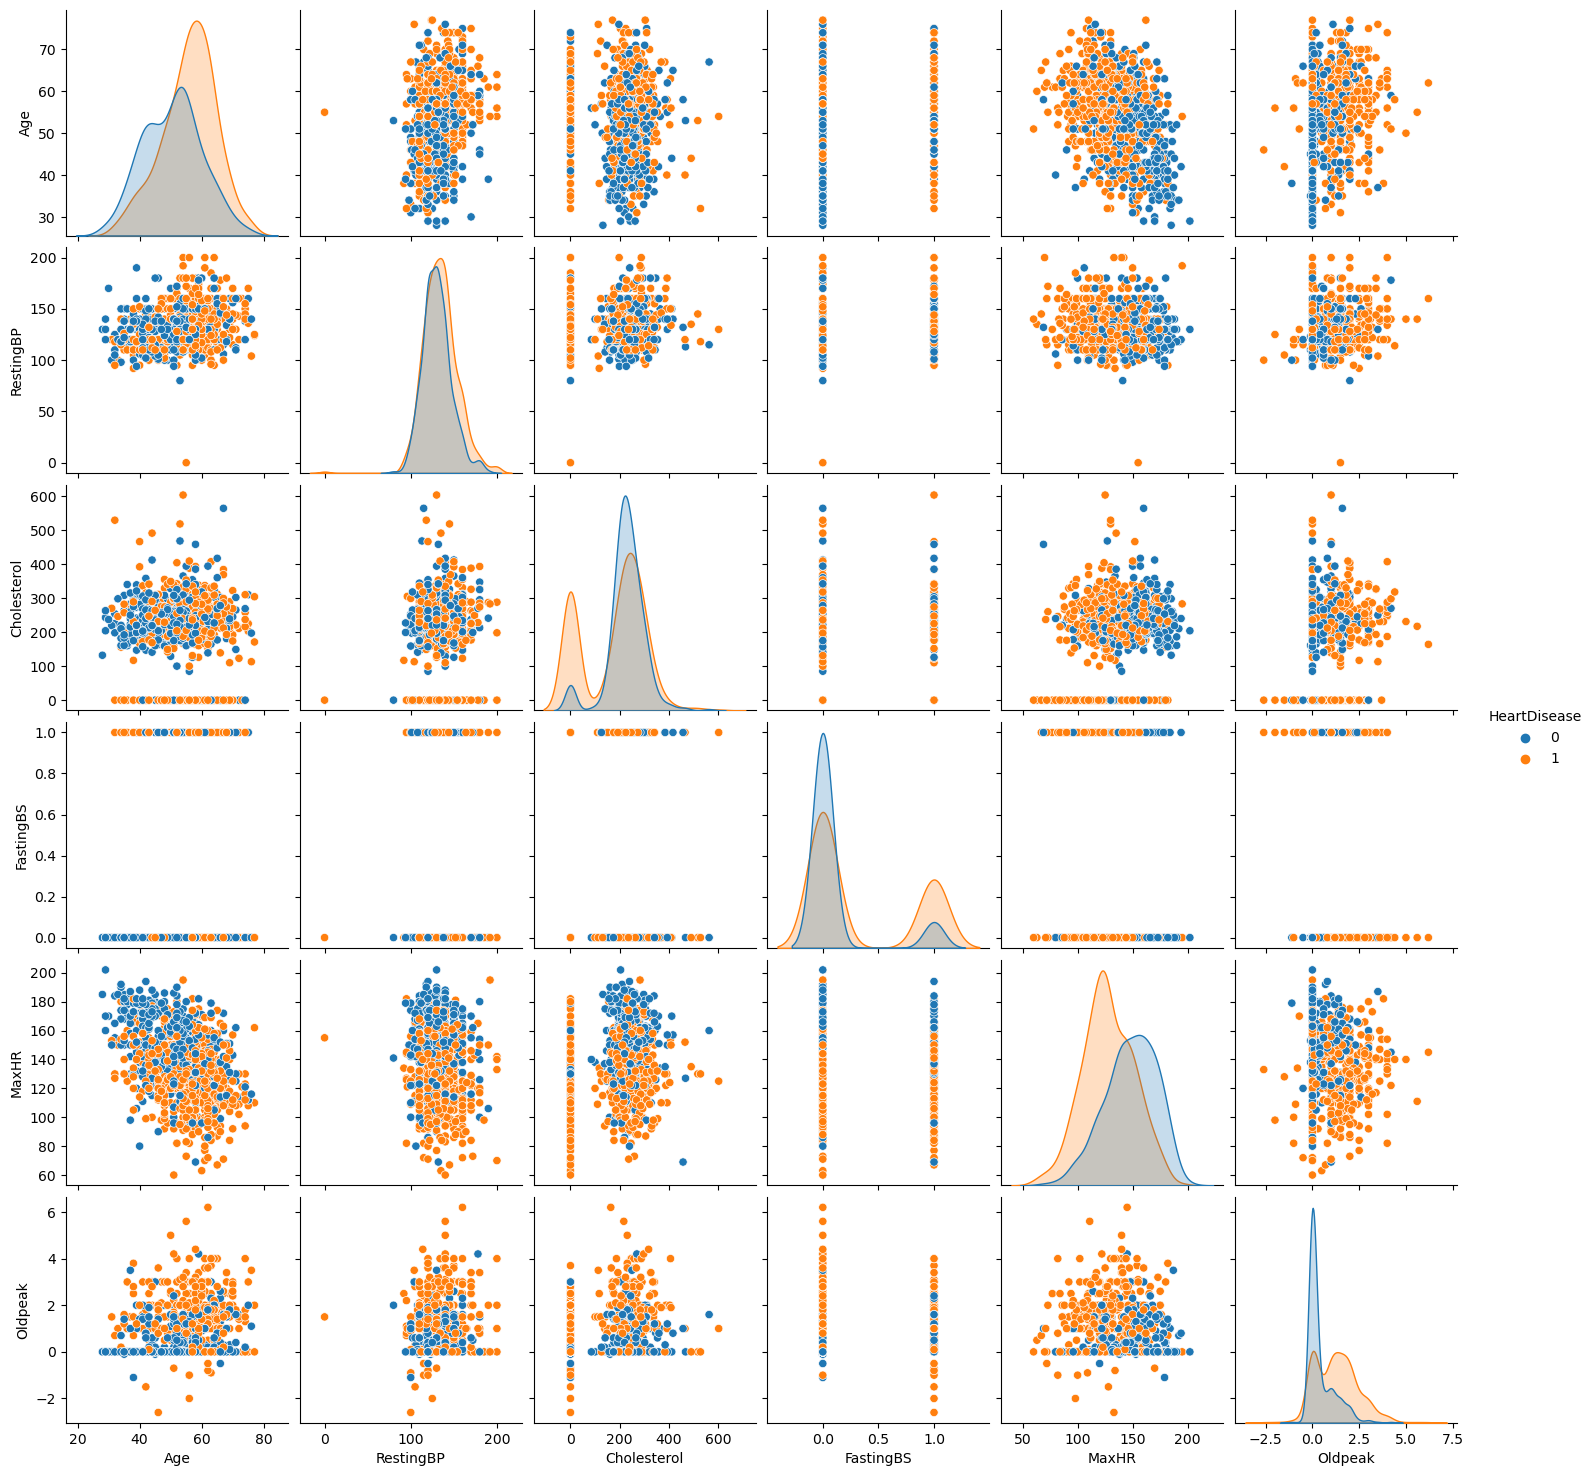

In [10]:
sns.pairplot(df, hue='HeartDisease')

## Features Catégorielles

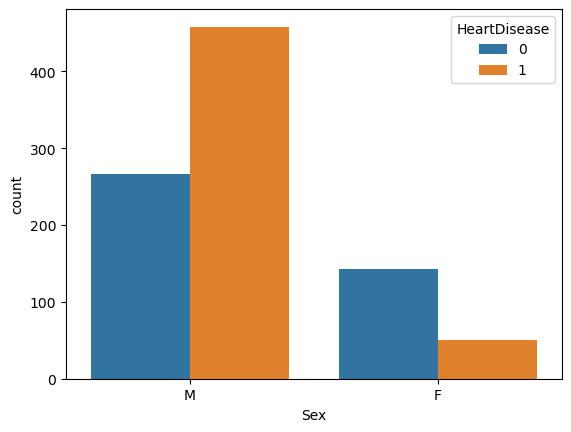

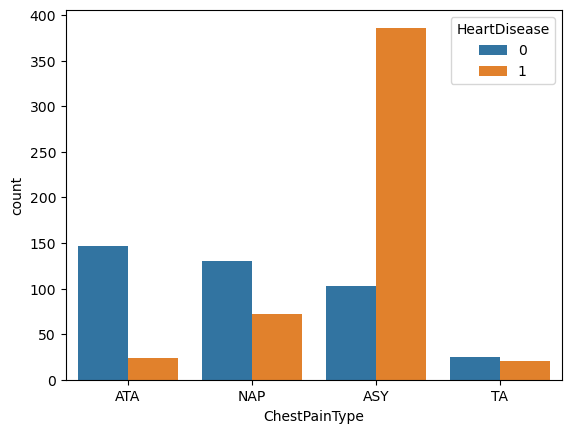

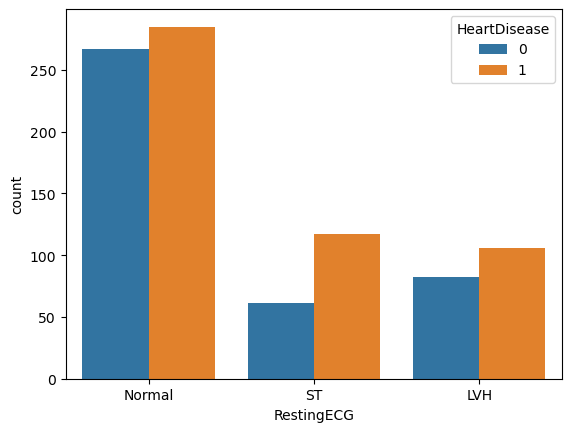

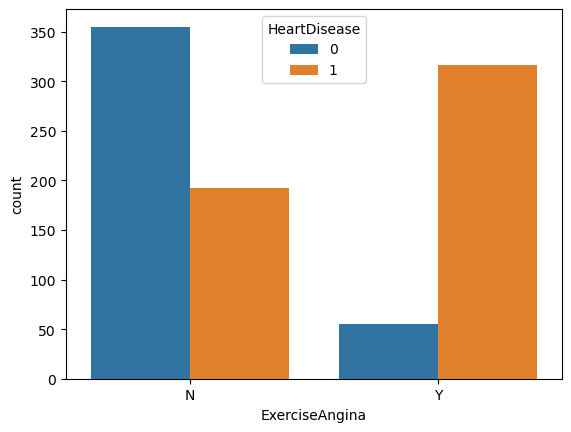

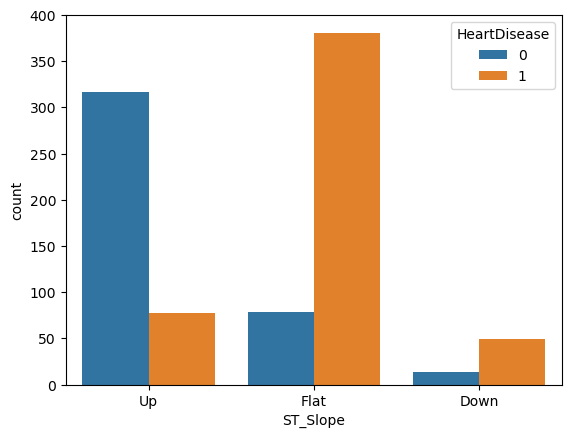

In [11]:
# on obeserve la distribution des variables cat. en prenant en compte la target
for column in df.select_dtypes('object').columns :
    sns.countplot(data=df, x=column, hue='HeartDisease')
    plt.show()

## Interprétations

Avec le pairplot nous obeservons quand croisant 2 variables numériques et en surlignant en couleur notre cible, nous observons facilement les clusters se former.


A titre d'exemple : 

Nous observons avec les graphs ci dessus que nous avons aussi une forte corrélation avec la colonne ST_Shape

Si nous appliquons tout bêtement une condition : si ST_Slope != 'Up' alors HeartDisease = 1 nous obtenons déjà un score de 0.81 déjà sans faire de ML nous obtenons un bon résultat avec juste une colonne.

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(df.HeartDisease,df.ST_Slope != 'Up')

0.8137254901960784

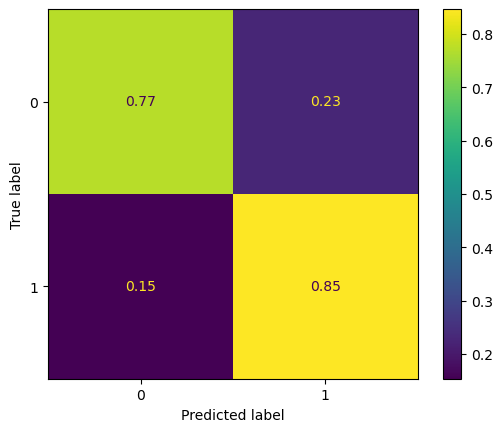

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
ConfusionMatrixDisplay(confusion_matrix(df.HeartDisease,df.ST_Slope != 'Up', normalize='true')).plot() # en normalisant nous observont 15% de Faux négatif

L'objectif va être maintenant de battre ce score avec du ML si nous n'y arrivons pas le ML serrait inutile

# ML

## Remplacement valeurs manquantes

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   907 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           899 non-null    float64
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 93.2+ KB


Nous avons 2 colonnes avec des valeurs manquantes : ChestPainType et MaxHR.
Nous allons commencer par MaxHR

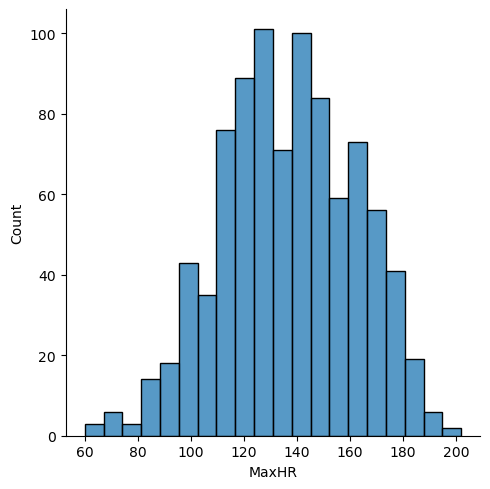

In [15]:
sns.displot(df.MaxHR)

In [16]:
from scipy import stats as st

In [17]:
df.MaxHR.median(), df.MaxHR.mean(), df.MaxHR.mode().iloc[0]

(138.0, 136.76974416017796, 150.0)

In [18]:
# au vu de la distribution et du résultat de la mediane, la moyenne et le mode, nous remplacerons les NaN par la median

In [19]:
median_maxhr = df.MaxHR.median()

In [20]:
df.MaxHR.fillna(median_maxhr, inplace=True)

In [21]:
df.ChestPainType.value_counts(dropna=False)

ASY    489
NAP    202
ATA    171
TA      45
NaN     11
Name: ChestPainType, dtype: int64

In [22]:
# pas besoin de remplacer les NaN pour ChestPainType, nous avons des variables catégorielles, la gestion des NaN sera faites lors de l'encodage

## Encodage

In [23]:
# Il faut factoriser certaines colonnes Sex et ExerciseAngina ( transformer M et F en 1 et 0 / et transformer Y et N en 1 et O)

In [24]:
df.Sex.value_counts()

M    725
F    193
Name: Sex, dtype: int64

In [25]:
df.ExerciseAngina.value_counts()

N    547
Y    371
Name: ExerciseAngina, dtype: int64

In [26]:
# deux méthode Replace ou factorize.

In [27]:
#df['Sex']=df.Sex.factorize()[0] mais difficile de voir à quoi corresponde le 0 et le 1

In [28]:
#df['Sex'] = df.Sex.replace({'M':1,'F':0}) plus simple de voir que le 1 correspond à M et 0 à F le dictionnaire nous donne une bonne info.

In [29]:
df['Sex'] = df.Sex.replace({'M':1,'F':0})
df['ExerciseAngina'] = df.ExerciseAngina.replace({'Y':1,'N':0})

In [30]:
df.Sex.value_counts()

1    725
0    193
Name: Sex, dtype: int64

In [31]:
df.ExerciseAngina.value_counts()

0    547
1    371
Name: ExerciseAngina, dtype: int64

In [32]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172.0,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156.0,0,1.0,Flat,1
2,37,1,NaN,130,283,0,ST,98.0,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108.0,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122.0,0,0.0,Up,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   907 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    float64
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 93.2+ KB


In [34]:
# Il nous reste 3 colonnes object que nous allons get_dummies.

In [35]:
index_nan = df[df.ChestPainType.isna()].index # on stock les lignes des NaN de ChestPainType

In [36]:
df[df.ChestPainType.isna()].head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
2,37,1,NaN,130,283,0,ST,98.0,0,0.0,Up,0
72,52,1,NaN,120,182,0,Normal,150.0,0,0.0,Flat,1
153,55,1,NaN,120,270,0,Normal,140.0,0,0.0,Up,0
167,48,1,NaN,140,238,0,Normal,118.0,0,0.0,Up,0
187,41,1,NaN,120,237,1,Normal,138.0,1,1.0,Flat,1


In [37]:
# les NaN dans la colonnes ChestPainType sont géré avec le get dummies ( nous récupérons l'index pour montrer le résultat)

In [38]:
df = pd.get_dummies(df, columns=['ChestPainType','RestingECG','ST_Slope'], dtype=bool)

In [39]:
df.iloc[index_nan][['ChestPainType_ASY','ChestPainType_ATA','ChestPainType_NAP','ChestPainType_TA']].head()

,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
2,False,False,False,False
72,False,False,False,False
153,False,False,False,False
167,False,False,False,False
187,False,False,False,False


In [40]:
#Nous observons ci dessous que là où nous avons des NaN pour ChestPainType nous avons toute les valeur du get_dummies à False

In [41]:
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172.0,0,0.0,0,False,True,False,False,False,True,False,False,False,True
1,49,0,160,180,0,156.0,0,1.0,1,False,False,True,False,False,True,False,False,True,False
2,37,1,130,283,0,98.0,0,0.0,0,False,False,False,False,False,False,True,False,False,True
3,48,0,138,214,0,108.0,1,1.5,1,True,False,False,False,False,True,False,False,True,False
4,54,1,150,195,0,122.0,0,0.0,0,False,False,True,False,False,True,False,False,False,True


In [42]:
df.isna().sum()

Age                  0
Sex                  0
RestingBP            0
Cholesterol          0
FastingBS            0
MaxHR                0
ExerciseAngina       0
Oldpeak              0
HeartDisease         0
ChestPainType_ASY    0
ChestPainType_ATA    0
ChestPainType_NAP    0
ChestPainType_TA     0
RestingECG_LVH       0
RestingECG_Normal    0
RestingECG_ST        0
ST_Slope_Down        0
ST_Slope_Flat        0
ST_Slope_Up          0
dtype: int64

In [43]:
# Notre DataFrame est pêt pour le machine learning, tout est encodé en valeur numérique et nous n'avons pas de NaN

## Choix du model de ML

### Model Selection

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X = df.drop(columns='HeartDisease')
y = df.HeartDisease

In [46]:
y.value_counts(normalize=True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

In [47]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, stratify=y) # 'toujours mettre stratify=y pour de la classification celà permet de garder les proportions dans notre test et train de la cible

In [48]:
y_train.value_counts(normalize=True)

1    0.553779
0    0.446221
Name: HeartDisease, dtype: float64

In [49]:
y_test.value_counts(normalize=True)

1    0.552174
0    0.447826
Name: HeartDisease, dtype: float64

### Preprocessing 

In [50]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [51]:
scaler = StandardScaler()

In [52]:
scaler.fit(X_train)

StandardScaler()

In [53]:
X_train_scaled = scaler.transform(X_train)

In [54]:
X_test_scaled = scaler.transform(X_test)

### Boucle pour les scores de chaque models

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import RandomForestClassifier

In [56]:
# Choix des modèles à utiliser dans un liste
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

In [57]:
for model in models :
    #print(model)
    print(type(model).__name__)
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    print('Train Score : {:.4f} , Test Score : {:.4f}'.format(model.score(X_train_scaled,y_train),model.score(X_test_scaled,y_test)))
    print("")
    print(50*'=')

LogisticRegression
Train Score : 0.8561 , Test Score : 0.8826

KNeighborsClassifier
Train Score : 0.8765 , Test Score : 0.8783

DecisionTreeClassifier
Train Score : 1.0000 , Test Score : 0.7826

RandomForestClassifier
Train Score : 1.0000 , Test Score : 0.8739



In [58]:
# Notre choix peux se concentrer sur notre RandomForest ou notre KNN

### KNN ou RF

#### RF

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
params = {
   'n_estimators' : [5,8,9,10,11,12,13,14,15,20],
    'max_depth' : [None,3,5,10],
    'min_samples_split':[2,5,8,10,15],
    'min_samples_leaf':[1,2,3]
}

RF = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=4, n_jobs=-1, verbose=10)

In [61]:
RF.fit(X_train_scaled,y_train)

Fitting 4 folds for each of 600 candidates, totalling 2400 fits
[CV 2/4; 1/600] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5
[CV 2/4; 1/600] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=5;, score=0.860 total time=   0.0s
[CV 4/4; 5/600] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=11
[CV 4/4; 5/600] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.785 total time=   0.0s
[CV 1/4; 8/600] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=14
[CV 1/4; 8/600] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=14;, score=0.826 total time=   0.0s
[CV 4/4; 10/600] START max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20
[CV 4/4; 10/600] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.831 total time=   0.0s
[CV 2/4; 14/600] START max_depth=None, min_samples_l

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 8, 10, 15],
                         'n_estimators': [5, 8, 9, 10, 11, 12, 13, 14, 15, 20]},
             verbose=10)

In [62]:
RF.best_params_

{'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 13}

In [63]:
RF.score(X_train_scaled,y_train),RF.score(X_test_scaled,y_test)

(0.9055232558139535, 0.8826086956521739)

In [64]:
y_pred_rf = RF.predict(X_test_scaled)

In [65]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

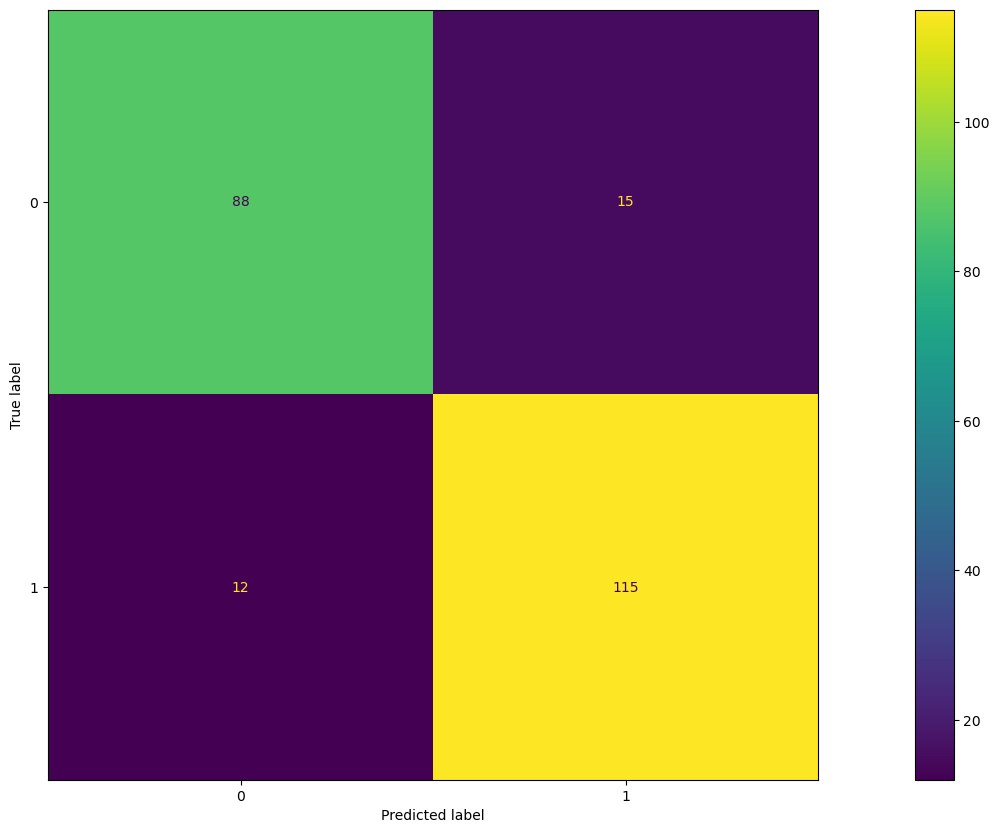

In [66]:
fig, ax= plt.subplots(figsize=(25, 10))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot(ax=plt.gca())

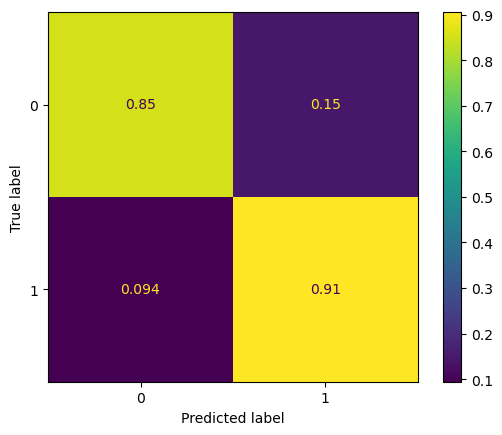

In [67]:
# voici la version plus petite normalizé pour comparé avec notre règle créer au début avec ST_Slope
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf,normalize='true')).plot()

In [68]:
# Analyse des probabilité

In [69]:
y_pred_proba_rf = RF.predict_proba(X_test_scaled)

In [70]:
data = {
    "HeartDisease_True":y_test,
    "HeartDisease_Pred":y_pred_rf,
    "Prob_HeartDisease = 1": y_pred_proba_rf[:,1]
}
test_pred_rf = pd.DataFrame(data)

In [71]:
test_pred_rf

,HeartDisease_True,HeartDisease_Pred,Prob_HeartDisease = 1
311,1,1,0.676224
52,0,0,0.109615
466,1,1,0.952244
310,0,1,0.502289
735,1,0,0.436412
...,...,...,...
566,0,1,1.000000
442,1,1,0.927330
416,1,1,0.945513
428,1,1,0.849602


#### KNN

In [72]:
params = {
   'n_neighbors' : [2,3,5,8],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p':[1,2,3]
}

KNN = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=4, n_jobs=-1, verbose=10)

In [73]:
KNN.fit(X_train_scaled,y_train)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [2, 3, 5, 8], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             verbose=10)

In [74]:
KNN.best_params_

{'algorithm': 'auto', 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}

In [75]:
KNN.score(X_train_scaled,y_train),KNN.score(X_test_scaled,y_test)

(0.8677325581395349, 0.8782608695652174)

In [76]:
y_pred_knn = KNN.predict(X_test_scaled)

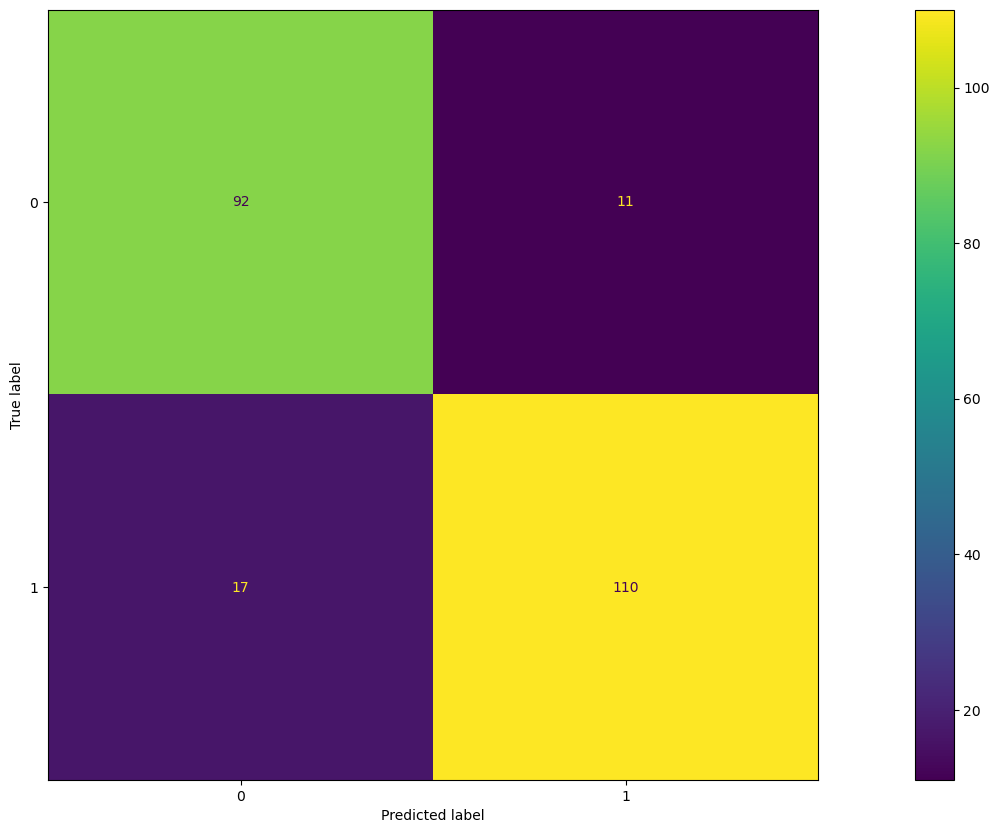

In [77]:
fig, ax= plt.subplots(figsize=(25, 10))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn)).plot(ax=plt.gca())

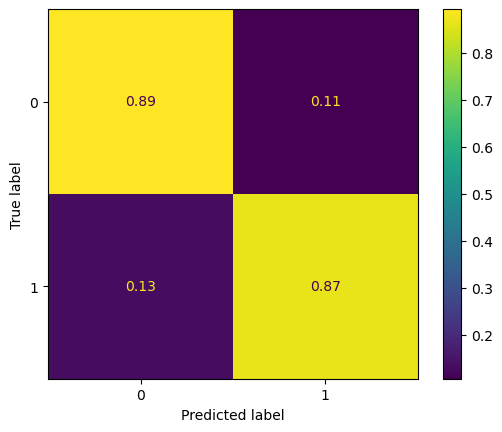

In [78]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn,normalize='true')).plot()

In [79]:
y_pred_proba_knn = KNN.predict_proba(X_test_scaled)

In [80]:
data = {
    "HeartDisease_True":y_test,
    "HeartDisease_Pred":y_pred_knn,
    "Prob_HeartDisease = 1": y_pred_proba_knn[:,1]
}
test_pred_knn = pd.DataFrame(data)

In [81]:
test_pred_knn

,HeartDisease_True,HeartDisease_Pred,Prob_HeartDisease = 1
311,1,1,0.875
52,0,0,0.000
466,1,1,0.875
310,0,0,0.250
735,1,0,0.500
...,...,...,...
566,0,1,1.000
442,1,1,1.000
416,1,1,0.875
428,1,1,0.875
